In [ ]:
### Goals: evaluate the CNN gamma model performance using different combinations of atmospheric variables as input
### CNN gamma model coding follows training_baseline_models_yhw_RampelOrder.ipynb
### model configuration follows Rampal et al. (2022)
### evaluate metrics follows evaluate_downscaling_performance.ipynb

This notebook focuses on identifying the optimal combination of atmospheric variables as input for downscaling precipitation using the CNN-Gamma model. It builds on prior work where a reasonable hyperparameter configuration for the model was determined. Several sets of atmospheric variables, selected based on domain knowledge, are tested in this demonstration. The variables include wind velocity at 850 hPa and total precipitation, evaluated under the following combinations:

- `['w850', 'u850', 'v850', 'tp']`
- `['w850', 'u850', 'v850']`
- `['w850']`
- `['tp']`

The goal is to understand the capabilities of low-level dynamic variables and surface precipitation in capturing precipitation characteristics.

## Key Methodology:
1. **Comparing Mean Precipitation**:
   - The mean precipitation over time is compared between model predictions and ground truth data.

2. **Performance Metrics**:
   - Metrics include:
     - **Explained Variance**
     - **Root Mean Squared Error (RMSE)**
     - **Bias in the 90th Percentile** for extreme precipitation events
   - Metrics are evaluated over the entire testing period at each spatial point, with distributions visualized using boxplots.
   - Note: Explained variance and RMSE are calculated for all days, not exclusively for wet days (e.g., >1 mm precipitation), which could affect the results.


In [1]:
# Load packages and set up paths
%load_ext autoreload
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import sys
import tensorflow as tf
import tensorflow.keras.backend as K
import cartopy.crs as ccrs

# my working paths
sys.path.append(r'/home/u1281808/High-res-interpretable-dl/src')
# change to the directory of the "src file" 
os.chdir(r'/home/u1281808/High-res-interpretable-dl')

from dask.diagnostics import ProgressBar
import cmocean
from models import train_model, complex_conv, simple_conv, predict, simple_dense, linear_complex_model
from losses import gamma_loss_1d, gamma_mse_metric
from prepare_data_Taiwan import format_features, prepare_training_dataset, create_test_train_split

from sklearn.metrics import explained_variance_score, mean_squared_error

tf.random.set_seed(2)

2025-01-07 03:10:11.009617: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 03:10:11.052986: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 03:10:11.054086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 03:10:11.793795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load paths and basic configurations
# overlapping period: 1981-2021
config = dict(
    y = "/home/u1281808/High-res-interpretable-dl/training_data/combined_TReAD_daily_RAINNC_19802021.nc",
    X = "/home/u1281808/High-res-interpretable-dl/training_data/combination.nc",
    train_start = "1981-01-01",
    train_end = "2010-12-31",
    val_start = "2011-01-01",
    val_end = "2015-12-31",
    test_start = "2016-01-01",
    test_end = "2021-12-31"
)


In [3]:
# Define function to generate and save predictions for combinations of input variables
def generate_predictions(input_vars):
    # Update config with selected input variables
    config["downscale_variables"] = input_vars
    
    x_train, x_val, x_test, y_train, y_val, y_test = create_test_train_split(config)
    x_train, x_test, x_val, y_train, y_test, y_val = prepare_training_dataset(x_train, x_val, x_test, y_train, y_val, y_test)
    
    x_train_np, x_val_np, x_test_np = x_train.values, x_val.values, x_test.values
    y_train_np, y_val_np, y_test_np = y_train['pr'].values, y_val['pr'].values, y_test['pr'].values
    
    input_shape = x_train_np.shape[1:]
    output_shape = y_train_np.shape[1]

    # Model Configuration from Hyperparameter-Tuning-CNN-Gamma-Nonlinear-Taiwan.ipynb
    cnn_gamma = complex_conv(
        layer_filters = [16, 32, 64],
        bn = True,
        padding = 'same',  # Avoid dimension shrinkage errors
        kernel_size = (3, 3),
        pooling = True,
        dense_layers = [256],
        dense_activation = 'relu',
        input_shape = input_shape,
        dropout = 0.4,
        activation = 'relu',
        output_shape = output_shape
    )

    # Train the model
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    
    train_model(
        cnn_gamma,
        [x_train_np, y_train_np],
        x_val = x_val_np,
        y_val = y_val_np, 
        loss = gamma_loss_1d,
        epochs = 40,
        batch_size = 64,
        optimizer = optimizer,
        model_weights_name = f'cnn_gamma_weights_{"_".join(input_vars)}_Taiwan.h5',
        metrics = gamma_mse_metric
    )   

    # Generate predictions
    gamma_prediction = predict(cnn_gamma, x_test, y_test, batch_size= 64, key = 'pr', pred_name = "test", loss = 'gamma', thres=0.5)
    print(gamma_prediction)

    gamma_prediction_ud= gamma_prediction.unstack()
    gamma_prediction_ud = gamma_prediction_ud.reindex(lon = sorted(gamma_prediction_ud.lon.values))
    print(gamma_prediction_ud)

    # Save predictions to file
    output_path = '/home/u1281808/High-res-interpretable-dl/output_data/'
    prediction_filename = os.path.join(output_path, f"predictions_{'_'.join(input_vars)}_Taiwan_tpadjust.nc")
    gamma_prediction_ud.to_netcdf(prediction_filename)
    print(f"Predictions saved as {prediction_filename}")
    

In [4]:
# Define different combinations of input variables
input_combinations = [
    ['w850', 'u850', 'v850', 'tp'],
    ['w850', 'u850', 'v850'],
    ['w850'],
    ['tp']
]

# Generate predictions for each combination of input variables
for combo in input_combinations:
    generate_predictions(combo)

[########################################] | 100% Completed | 203.25 ms
[########################################] | 100% Completed | 610.75 ms
[########################################] | 100% Completed | 102.58 ms
[########################################] | 100% Completed | 319.10 ms
[########################################] | 100% Completed | 102.01 ms
[########################################] | 100% Completed | 506.49 ms
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 33, 37, 4)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 33, 37, 16)           592       ['input_1[0][0]']             
                                                          

2025-01-07 03:10:41.956692: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-01-07 03:10:41.969549: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1794] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Epoch 1/40
171/171 [==============================] - 22s 118ms/step - loss: 0.1826 - gamma_mse_metric: 0.7587 - val_loss: 0.2320 - val_gamma_mse_metric: 0.6640 - lr: 1.0000e-04
Epoch 2/40
171/171 [==============================] - 19s 113ms/step - loss: 0.0538 - gamma_mse_metric: 0.6073 - val_loss: 0.2133 - val_gamma_mse_metric: 0.5896 - lr: 1.0000e-04
Epoch 3/40
171/171 [==============================] - 20s 116ms/step - loss: 0.0497 - gamma_mse_metric: 0.8160 - val_loss: 0.1923 - val_gamma_mse_metric: 0.7508 - lr: 1.0000e-04
Epoch 4/40
171/171 [==============================] - 20s 114ms/step - loss: 0.0477 - gamma_mse_metric: 1.1372 - val_loss: 0.1928 - val_gamma_mse_metric: 1.4590 - lr: 1.0000e-04
Epoch 5/40
171/171 [==============================] - 20s 117ms/step - loss: 0.0458 - gamma_mse_metric: 0.8050 - val_loss: 0.1803 - val_gamma_mse_metric: 0.9070 - lr: 1.0000e-04
Epoch 6/40
171/171 [==============================] - 20s 116ms/step - loss: 0.0452 - gamma_mse_metric: 0.7423

In [5]:
### Evaluate model performance
# Load groundtruth data, created in training_baseline_models_yhw_Rampel2Taiwan.ipynb
gt = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/groundtruth_to_evalute_predictions_Taiwan.nc')['pr']
print(gt)

# # saved predictions from the NetCDF file, created in training_baseline_models_yhw_RampelOrder.ipynb
predict_4vars = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/predictions_w850_u850_v850_tp_Taiwan_tpadjust.nc')['test']
print(predict_4vars)

predict_3vars = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/predictions_w850_u850_v850_Taiwan_tpadjust.nc')['test']
print(predict_3vars)

predict_w850 = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/predictions_w850_Taiwan_tpadjust.nc')['test']
print(predict_w850)

predict_tp = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/predictions_tp_Taiwan_tpadjust.nc')['test']
print(predict_tp)


<xarray.DataArray 'pr' (time: 2188, lat: 173, lon: 101)>
[38230924 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 21.88 21.9 21.92 21.94 ... 25.26 25.28 25.3 25.32
  * lon      (lon) float32 120.0 120.0 120.0 120.1 ... 121.9 122.0 122.0 122.0
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2021-12-31
Attributes:
    units:           mm
    long_name:       
    description:     ACCUMULATED TOTAL GRID SCALE PRECIPITATION
    comment:         1980-01-01 to 1980-12-31
    average_op_ncl:  dim_avg_n over dimension(s): Hour
<xarray.DataArray 'test' (time: 2188, lat: 173, lon: 101)>
[38230924 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 21.88 21.9 21.92 21.94 ... 25.26 25.28 25.3 25.32
  * lon      (lon) float32 120.0 120.0 120.0 120.1 ... 121.9 122.0 122.0 122.0
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2021-12-31
Attributes:
    units:           mm
    long_name:       
    description:     ACCUMULATED TOTAL GRID SCA

/tmp/ipykernel_309/765250683.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


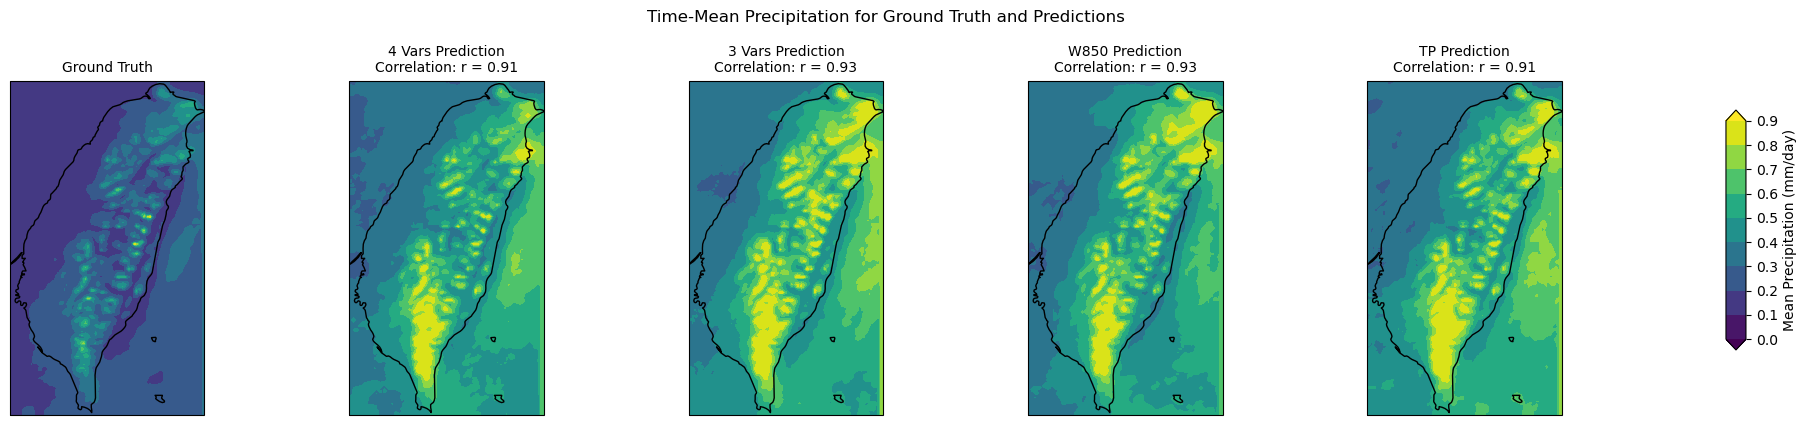

In [6]:
# Calculate time-mean precipitation for all datasets
datasets = {
    'Ground Truth': gt.mean(dim='time'),
    '4 Vars Prediction': predict_4vars.mean(dim='time'),
    '3 Vars Prediction': predict_3vars.mean(dim='time'),
    'W850 Prediction': predict_w850.mean(dim='time'),
    'TP Prediction': predict_tp.mean(dim='time')
}

# Set colorbar range and levels
vmin, vmax = 0, 0.9
levels = np.arange(0, 1.0, 0.1)

# Function to calculate spatial correlation
def calculate_spatial_correlation(groundtruth, prediction):
    # Flatten and drop NaN values for correlation
    gt_flat = groundtruth.values.flatten()
    pred_flat = prediction.values.flatten()
    mask = ~np.isnan(gt_flat) & ~np.isnan(pred_flat)
    return np.corrcoef(gt_flat[mask], pred_flat[mask])[0, 1]

# Create a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Ground truth data for correlation calculation
gt_mean = datasets['Ground Truth']

# Plot each dataset
for ax, (title, data) in zip(axes, datasets.items()):
    # Clip values outside range for consistent colorbar scaling
    data_clipped = data.where(data > 0).clip(vmin, vmax)
    
    # Calculate spatial correlation (skip for Ground Truth itself)
    if title != 'Ground Truth':
        correlation = calculate_spatial_correlation(gt_mean, data_clipped)
        title += f'\nCorrelation: r = {correlation:.2f}'
    
    # Plot the data
    contour = ax.contourf(
        data_clipped['lon'], data_clipped['lat'], data_clipped,
        levels=levels, cmap='viridis', extend='both'
    )
    
    # Add coastline for clarity
    ax.coastlines(resolution='10m', color='black')
    
    # Title for each subplot
    ax.set_title(title, fontsize=10)
    
    # Hide ticks
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.6])  # Position of the colorbar
cbar = plt.colorbar(contour, cax=cbar_ax, ticks=levels)
cbar.set_label('Mean Precipitation (mm/day)')  # Added units here

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.suptitle('Time-Mean Precipitation for Ground Truth and Predictions', fontsize=12, y=1.05)
plt.savefig('/home/u1281808/High-res-interpretable-dl/output_data/AnnualMean_inputvars_cnngamma_Taiwan_tpadjust.png', dpi=300)
plt.show()
plt.close()


/tmp/ipykernel_309/1127989574.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


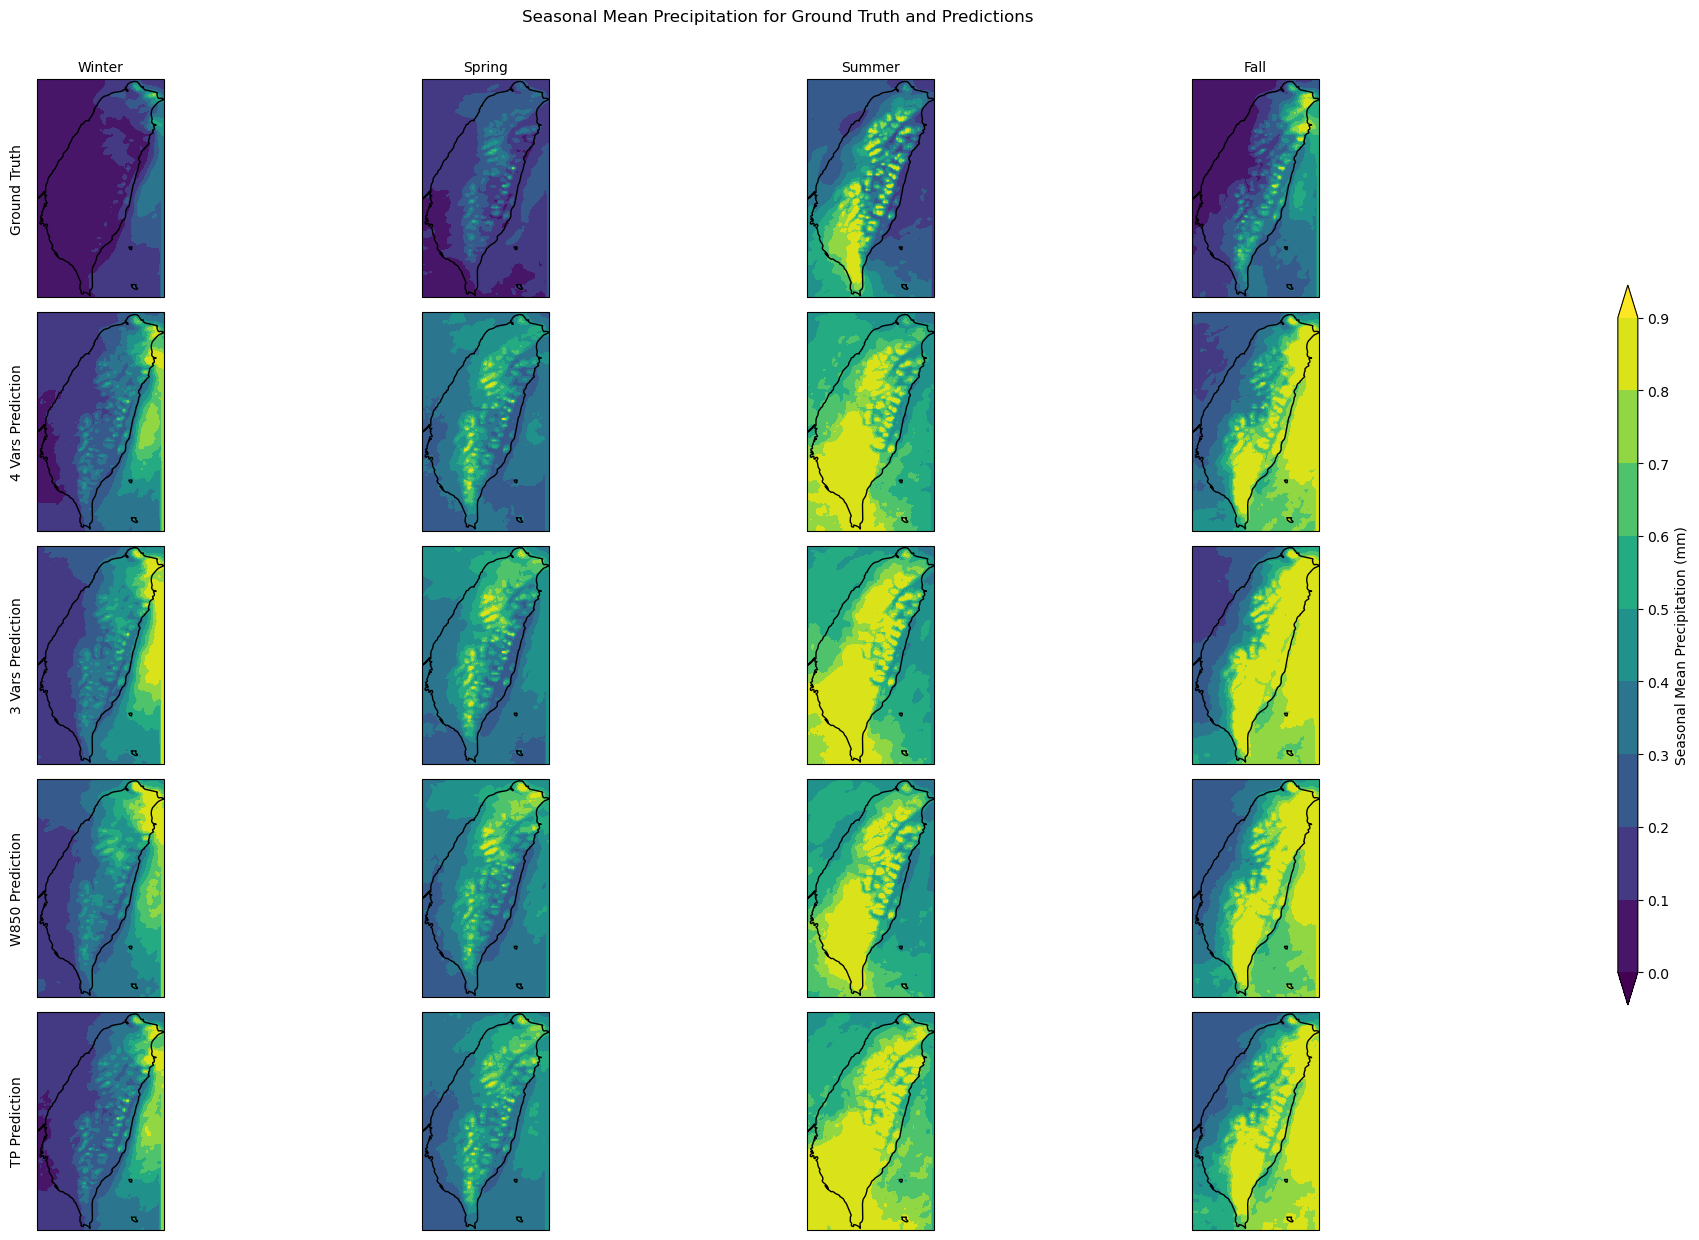

In [7]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the datasets
gt = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/groundtruth_to_evalute_predictions_Taiwan.nc')['pr']
predict_4vars = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/predictions_w850_u850_v850_tp_Taiwan_tpadjust.nc')['test']
predict_3vars = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/predictions_w850_u850_v850_Taiwan_tpadjust.nc')['test']
predict_w850 = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/predictions_w850_Taiwan_tpadjust.nc')['test']
predict_tp = xr.open_dataset('/home/u1281808/High-res-interpretable-dl/output_data/predictions_tp_Taiwan_tpadjust.nc')['test']

# Define seasons: Winter (DJF), Spring (MAM), Summer (JJA), Fall (SON)
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Compute seasonal means for each dataset
def compute_seasonal_mean(data):
    return {season: data.where(data['time'].dt.month.isin(months)).mean(dim='time') for season, months in seasons.items()}

seasonal_means = {
    'Ground Truth': compute_seasonal_mean(gt),
    '4 Vars Prediction': compute_seasonal_mean(predict_4vars),
    '3 Vars Prediction': compute_seasonal_mean(predict_3vars),
    'W850 Prediction': compute_seasonal_mean(predict_w850),
    'TP Prediction': compute_seasonal_mean(predict_tp)
}

# Set colorbar range and levels
vmin, vmax = 0, 0.9
levels = np.arange(0, 1.0, 0.1)

# Plot the seasonal means for each dataset
fig, axes = plt.subplots(5, 4, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop over datasets and seasons to create subplots
for row, (dataset_name, seasonal_data) in enumerate(seasonal_means.items()):
    for col, season in enumerate(seasons.keys()):
        ax = axes[row, col]
        data_clipped = seasonal_data[season].where(seasonal_data[season] > 0).clip(vmin, vmax)
        
        # Plot the seasonal mean data
        contour = ax.contourf(
            data_clipped['lon'], data_clipped['lat'], data_clipped,
            levels=levels, cmap='viridis', extend='both'
        )
        
        # Add coastline for clarity
        ax.coastlines(resolution='10m', color='black')
        
        # Remove ticks
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Add subplot title for seasons
        if row == 0:
            ax.set_title(season, fontsize=10)
        
        # Add dataset labels
        if col == 0:
            ax.text(-0.1, 0.5, dataset_name, va='center', ha='right',
                    rotation='vertical', transform=ax.transAxes, fontsize=10)

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.6])  # Position of the colorbar
cbar = plt.colorbar(contour, cax=cbar_ax, ticks=levels)
cbar.set_label('Seasonal Mean Precipitation (mm)')

# Adjust layout and add overall title
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.suptitle('Seasonal Mean Precipitation for Ground Truth and Predictions', fontsize=12, y=1.03)
plt.show()


In [8]:
### calculate three metrics used in Rampal et al. (2022)
from sklearn.metrics import r2_score, mean_squared_error

def compute_metrics_over_time(predicted, actual):
    # Initialize arrays to store metrics for each spatial point
    explained_variance = np.zeros((predicted.sizes['lat'], predicted.sizes['lon']))
    rmse = np.zeros((predicted.sizes['lat'], predicted.sizes['lon']))
    bias_90th = np.zeros((predicted.sizes['lat'], predicted.sizes['lon']))
    
    # Loop over each spatial point (lat, lon)
    for i in range(predicted.sizes['lat']):
        for j in range(predicted.sizes['lon']):
            # Flatten the time series for the specific (lat, lon) point
            pred_series = predicted[:, i, j].values.flatten()
            actual_series = actual[:, i, j].values.flatten()

            # Remove NaN values
            mask = ~np.isnan(pred_series) & ~np.isnan(actual_series)
            pred_series_clean = pred_series[mask]
            actual_series_clean = actual_series[mask]

            if len(pred_series_clean) > 0:  # Ensure there are valid values left
                # Compute explained variance (R²)
                explained_variance[i, j] = r2_score(actual_series_clean, pred_series_clean)

                # Compute RMSE
                rmse[i, j] = np.sqrt(mean_squared_error(actual_series_clean, pred_series_clean))

                # Compute bias (90th percentile difference)
                pred_90th = np.percentile(pred_series_clean, 90)
                actual_90th = np.percentile(actual_series_clean, 90)
                bias_90th[i, j] = pred_90th - actual_90th
            else:
                # Assign NaN if no valid data
                explained_variance[i, j] = np.nan
                rmse[i, j] = np.nan
                bias_90th[i, j] = np.nan
    
    return explained_variance, rmse, bias_90th




# measure computing time
import time
# Start the timer
start_time = time.time()

# Apply the function over all days
explained_variance_4vars, rmse_4vars, bias_90th_4vars = compute_metrics_over_time(predict_4vars, gt)
explained_variance_3vars, rmse_3vars, bias_90th_3vars = compute_metrics_over_time(predict_3vars, gt)
explained_variance_w850, rmse_w850, bias_90th_w850 = compute_metrics_over_time(predict_w850, gt)
explained_variance_tp, rmse_tp, bias_90th_tp = compute_metrics_over_time(predict_tp, gt)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"The code took {elapsed_time:.2f} seconds to run.")


The code took 3949.81 seconds to run.


In [10]:
# Save metrics of indivisual models in a netcdf file to avoid rerunning the code above

# Create a dataset for each model's metrics
ds = xr.Dataset(
    {
       
        # Most Variables
        "explained_variance_4vars": (["lat", "lon"], explained_variance_4vars),
        "rmse_4vars": (["lat", "lon"], rmse_4vars),
        "bias_90th_4vars": (["lat", "lon"], bias_90th_4vars),

        # 3 Variables
        "explained_variance_3vars": (["lat", "lon"], explained_variance_3vars),
        "rmse_3vars": (["lat", "lon"], rmse_3vars),
        "bias_90th_3vars": (["lat", "lon"], bias_90th_3vars),
        
        # w850 only
        "explained_variance_w850": (["lat", "lon"], explained_variance_w850),
        "rmse_w850": (["lat", "lon"], rmse_w850),
        "bias_90th_w850": (["lat", "lon"], bias_90th_w850),
        
        # tp only
        "explained_variance_tp": (["lat", "lon"], explained_variance_tp),
        "rmse_tp": (["lat", "lon"], rmse_tp),
        "bias_90th_tp": (["lat", "lon"], bias_90th_tp),
    },
    coords={
        "lat": gt['lat'],
        "lon": gt['lon']
    }
)

# Save the dataset to a NetCDF file
output_path = "/home/u1281808/High-res-interpretable-dl/output_data/model_performance_metrics_inputcomp_Taiwan_tpadjust.nc"
ds.to_netcdf(output_path)

print(f"Metrics saved to {output_path}")

Metrics saved to /home/u1281808/High-res-interpretable-dl/output_data/model_performance_metrics_inputcomp_Taiwan_tpadjust.nc


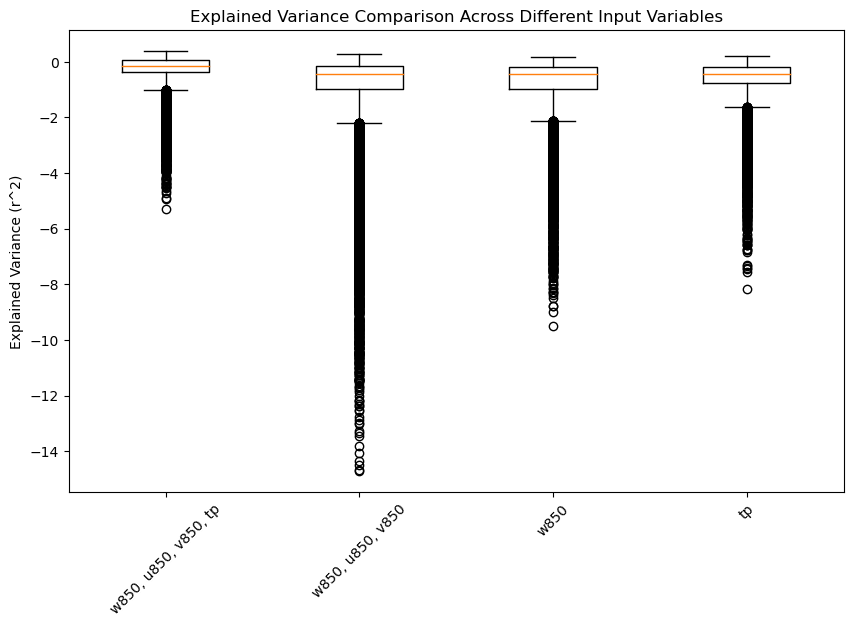

In [11]:
### create box-whisker plots using all spatial points, similar to Figure 3 of Rampal et al. (2022)

# Load the NetCDF file
ds = xr.open_dataset("/home/u1281808/High-res-interpretable-dl/output_data/model_performance_metrics_inputcomp_Taiwan_tpadjust.nc")

# Flatten the data to 1D arrays for box-whisker plot (Example: RMSE for all models)
explained_variance_4vars_flat = ds["explained_variance_4vars"].values.flatten()
explained_variance_3vars_flat = ds["explained_variance_3vars"].values.flatten()
explained_variance_w850_flat = ds["explained_variance_w850"].values.flatten()
explained_variance_tp_flat = ds["explained_variance_tp"].values.flatten()

# Remove NaN values from each array using np.isnan
explained_variance_4vars_flat = explained_variance_4vars_flat[~np.isnan(explained_variance_4vars_flat)]
explained_variance_3vars_flat = explained_variance_3vars_flat[~np.isnan(explained_variance_3vars_flat)]
explained_variance_w850_flat = explained_variance_w850_flat[~np.isnan(explained_variance_w850_flat)]
explained_variance_tp_flat = explained_variance_tp_flat[~np.isnan(explained_variance_tp_flat)]

# Create a box-whisker plot for RMSE comparison across models
plt.figure(figsize=(10, 6))
plt.boxplot(
    [explained_variance_4vars_flat, explained_variance_3vars_flat, explained_variance_w850_flat, explained_variance_tp_flat],
    labels=['w850, u850, v850, tp', 'w850, u850, v850', 'w850', 'tp']
)
plt.xticks(rotation=45)
plt.title("Explained Variance Comparison Across Different Input Variables")
plt.ylabel("Explained Variance (r^2)")

plt.savefig('/home/u1281808/High-res-interpretable-dl/output_data/r2_inputvars_cnngamma_Taiwan_tpadjust.png', dpi = 300)

# Display the plot
plt.show()

# Close the plot to free up memory
plt.close()

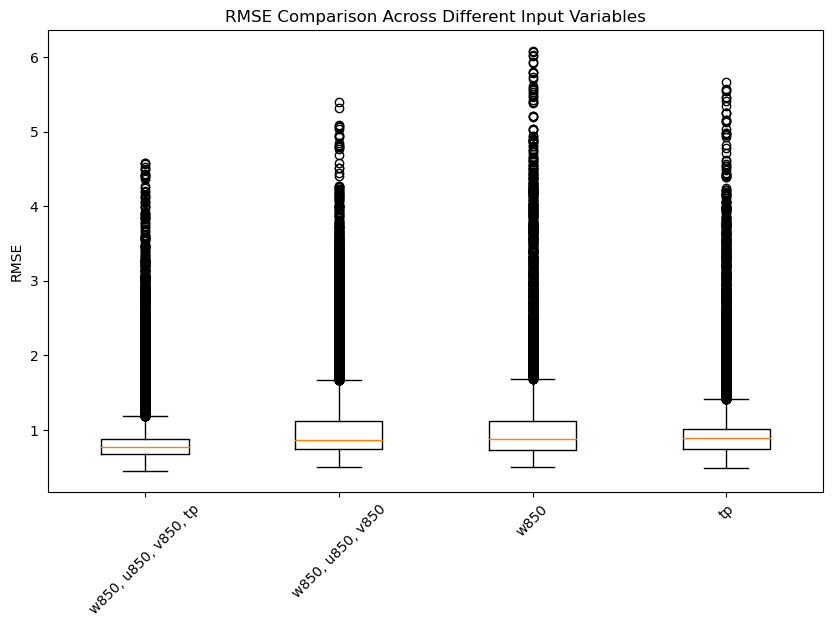

In [12]:
# Flatten the data to 1D arrays for box-whisker plot (Example: RMSE for all models)
rmse_4vars_flat = ds["rmse_4vars"].values.flatten()
rmse_3vars_flat = ds["rmse_3vars"].values.flatten()
rmse_w850_flat = ds["rmse_w850"].values.flatten()
rmse_tp_flat = ds["rmse_tp"].values.flatten()

# Remove NaN values from each array using np.isnan
rmse_4vars_flat = rmse_4vars_flat[~np.isnan(rmse_4vars_flat)]
rmse_3vars_flat = rmse_3vars_flat[~np.isnan(rmse_3vars_flat)]
rmse_w850_flat = rmse_w850_flat[~np.isnan(rmse_w850_flat)]
rmse_tp_flat = rmse_tp_flat[~np.isnan(rmse_tp_flat)]

# Create a box-whisker plot for RMSE comparison across models
plt.figure(figsize=(10, 6))
plt.boxplot(
    [rmse_4vars_flat, rmse_3vars_flat, rmse_w850_flat, rmse_tp_flat],
    labels=['w850, u850, v850, tp', 'w850, u850, v850', 'w850', 'tp']
)
plt.xticks(rotation=45)
plt.title("RMSE Comparison Across Different Input Variables")
plt.ylabel("RMSE")

plt.savefig('/home/u1281808/High-res-interpretable-dl/output_data/rmse_inputvars_cnngamma_Taiwan_tpadjust.png', dpi = 300)

# Display the plot
plt.show()

# Close the plot to free up memory
plt.close()

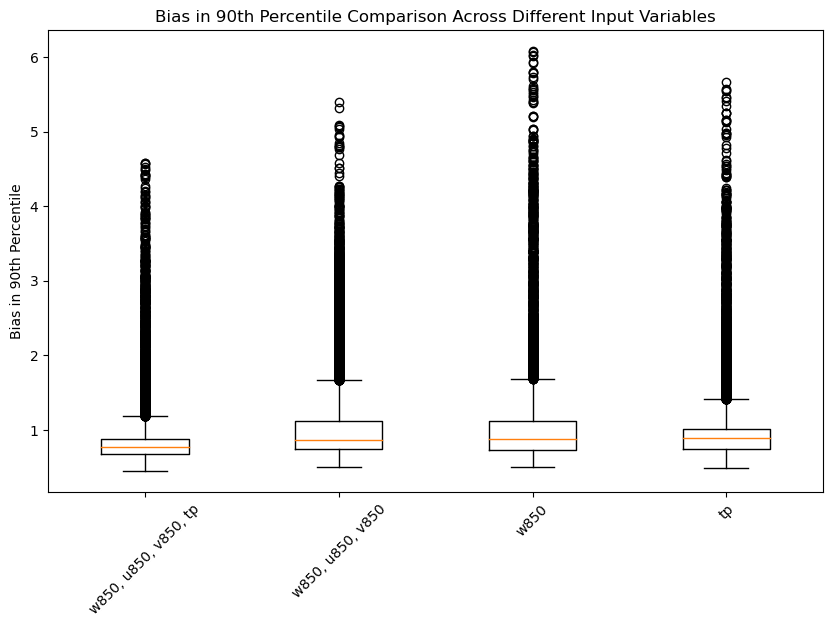

In [13]:
# Flatten the data to 1D arrays for box-whisker plot (Example: RMSE for all models)
bias_90th_4vars_flat = ds["bias_90th_4vars"].values.flatten()
bias_90th_3vars_flat = ds["bias_90th_3vars"].values.flatten()
bias_90th_w850_flat = ds["bias_90th_w850"].values.flatten()
bias_90th_tp_flat = ds["bias_90th_tp"].values.flatten()

# Remove NaN values from each array using np.isnan
bias_90th_4vars_flat = bias_90th_4vars_flat[~np.isnan(bias_90th_4vars_flat)]
bias_90th_3vars_flat = bias_90th_3vars_flat[~np.isnan(bias_90th_3vars_flat)]
bias_90th_w850_flat = bias_90th_w850_flat[~np.isnan(bias_90th_w850_flat)]
bias_90th_tp_flat = bias_90th_tp_flat[~np.isnan(bias_90th_tp_flat)]

# Create a box-whisker plot for RMSE comparison across models
plt.figure(figsize=(10, 6))
plt.boxplot(
    [rmse_4vars_flat, rmse_3vars_flat, rmse_w850_flat, rmse_tp_flat],
    labels=['w850, u850, v850, tp', 'w850, u850, v850', 'w850', 'tp']
)
plt.xticks(rotation=45)
plt.title("Bias in 90th Percentile Comparison Across Different Input Variables")
plt.ylabel("Bias in 90th Percentile")

plt.savefig('/home/u1281808/High-res-interpretable-dl/output_data/bias90th_inputvars_cnngamma_Taiwan_tpadjust.png', dpi=300)
plt.show()
plt.close()

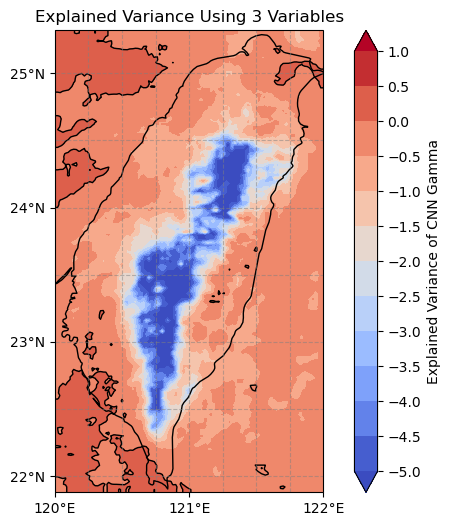

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np

explained_variance_3vars = ds['explained_variance_3vars']

# Clip values smaller than -5 to -5
explained_variance_clipped = np.clip(explained_variance_3vars, -5, None)  # Clip at -5

# Create figure with geographic projection
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree projection

# Plot the explained variance data with modified levels
contour = ax.contourf(
    gt['lon'], gt['lat'], explained_variance_clipped, 
    cmap='coolwarm', 
    levels=np.arange(-5, 1.1, 0.5),  # Define levels from -5 to 2.5 with 0.5 intervals
    extend='both',  # Ensure colors cover clipped values
    transform=ccrs.PlateCarree()  # Ensure data is properly projected
)

# Add a colorbar with specific range and intervals
cbar = plt.colorbar(contour, ax=ax, ticks=np.arange(-5, 1.1, 0.5))
cbar.set_label('Explained Variance of CNN Gamma')

# Overlay a contour line for 0
ax.contour(
    gt['lon'], gt['lat'], explained_variance_clipped, 
    levels=[0], colors='black', linewidths=1, 
    transform=ccrs.PlateCarree()
)

# Add Taiwan's coastline using Cartopy's built-in feature
ax.coastlines(resolution='10m', color='black')  # High-resolution coastline

# Set specific longitude and latitude ticks
xticks = [120, 121, 122]  # Longitude ticks
yticks = [22, 23, 24, 25]  # Latitude ticks
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

# Format ticks as longitude and latitude
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# Remove gridline labels to avoid overlap with ticks
gl = ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)

# Optional: Add land and borders for better context
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

# Add title
plt.title('Explained Variance Using 3 Variables')
plt.savefig('/home/u1281808/High-res-interpretable-dl/output_data/r2_3vars_cnngamma_Taiwan.png', dpi=300)
plt.show()
plt.close()


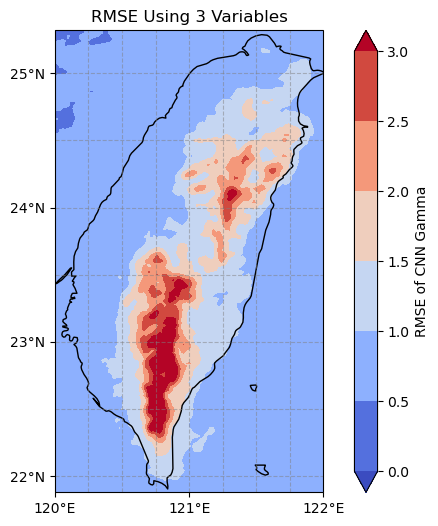

In [35]:
# Clip values smaller than -5 to -5
# explained_variance_clipped = np.clip(explained_variance_4vars, -5, None)  # Clip at -5

# Create figure with geographic projection
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree projection

# Plot the explained variance data with modified levels
contour = ax.contourf(
    gt['lon'], gt['lat'], rmse_3vars, 
    cmap='coolwarm', 
    levels=np.arange(0, 3.1, 0.5),  # Define levels from -5 to 2.5 with 0.5 intervals
    extend='both',  # Ensure colors cover clipped values
    transform=ccrs.PlateCarree()  # Ensure data is properly projected
)

# Add a colorbar with specific range and intervals
cbar = plt.colorbar(contour, ax=ax, ticks=np.arange(0, 3.1, 0.5))
cbar.set_label('RMSE of CNN Gamma')

# Overlay a contour line for 0
ax.contour(
    gt['lon'], gt['lat'], rmse_3vars, 
    levels=[0], colors='black', linewidths=1, 
    transform=ccrs.PlateCarree()
)

# Add Taiwan's coastline using Cartopy's built-in feature
ax.coastlines(resolution='10m', color='black')  # High-resolution coastline

# Set specific longitude and latitude ticks
xticks = [120, 121, 122]  # Longitude ticks
yticks = [22, 23, 24, 25]  # Latitude ticks
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

# Format ticks as longitude and latitude
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# Remove gridline labels to avoid overlap with ticks
gl = ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)

# Optional: Add land and borders for better context
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

# Add title
plt.title('RMSE Using 3 Variables')
plt.savefig('/home/u1281808/High-res-interpretable-dl/output_data/rmse_3vars_cnngamma_Taiwan.png', dpi=300)
plt.show()
plt.close()





#plt.figure(figsize=(8, 6))
#plt.contourf(gt['lon'], gt['lat'], rmse_4vars, cmap='coolwarm')
#plt.colorbar(label='RMSE of CNN Gamma')
#plt.title('RMSE Using 4 variables')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')

#
#plt.show()
#

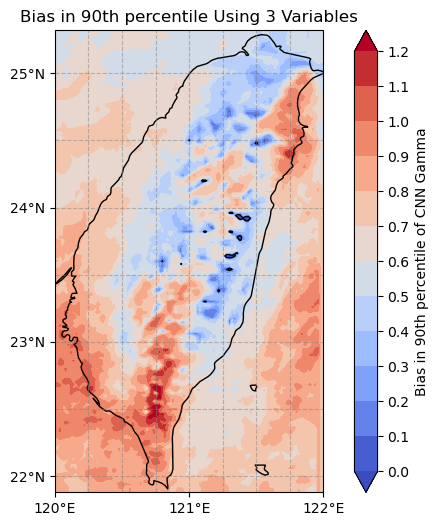

In [36]:
# Create figure with geographic projection
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree projection

# Plot the explained variance data with modified levels
contour = ax.contourf(
    gt['lon'], gt['lat'], bias_90th_3vars, 
    cmap='coolwarm', 
    levels=np.arange(0, 1.3, 0.1),  # Define levels from -5 to 2.5 with 0.5 intervals
    extend='both',  # Ensure colors cover clipped values
    transform=ccrs.PlateCarree()  # Ensure data is properly projected
)

# Add a colorbar with specific range and intervals
cbar = plt.colorbar(contour, ax=ax, ticks=np.arange(0, 1.3, 0.1))
cbar.set_label('Bias in 90th percentile of CNN Gamma')

# Overlay a contour line for 0
ax.contour(
    gt['lon'], gt['lat'], bias_90th_3vars, 
    levels=[0], colors='black', linewidths=1, 
    transform=ccrs.PlateCarree()
)

# Add Taiwan's coastline using Cartopy's built-in feature
ax.coastlines(resolution='10m', color='black')  # High-resolution coastline

# Set specific longitude and latitude ticks
xticks = [120, 121, 122]  # Longitude ticks
yticks = [22, 23, 24, 25]  # Latitude ticks
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

# Format ticks as longitude and latitude
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# Remove gridline labels to avoid overlap with ticks
gl = ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)

# Optional: Add land and borders for better context
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

# Add title
plt.title('Bias in 90th percentile Using 3 Variables')
plt.savefig('/home/u1281808/High-res-interpretable-dl/output_data/bias90th_3vars_cnngamma.png', dpi=300)
plt.show()
plt.close()


## Key Observations:
- Predictions from different input variable combinations capture the spatial distribution of mean precipitation in general but tend to overestimate its magnitude.
- Extreme precipitation is consistently overestimated by the model.
- **Explained Variance**:
  - Negative values are observed in most areas, likely due to the inclusion of all days (instead of focusing solely on wet days), leading to greater variance between predictions and ground truth.

## Best Combination:
Among the tested combinations, the set `['w850', 'u850', 'v850', 'tp']` (including both dynamic fields and total precipitation) resulted in the lowest errors across metrics.

## Potential Next Steps:
- Adapt the code to include different or additional variables, such as **topography**, to address errors in high-elevation areas.
- Revise performance metrics, particularly explained variance and RMSE, to focus on wet days (>1 mm precipitation) for improved insights.
- Expand metrics to include other measures, such as **Mean Absolute Error (MAE)**, based on specific questions of interest.

This notebook demonstrates how variable selection impacts downscaled precipitation predictions and highlights areas for future refinement and exploration.
